# News Type Classification with NLP

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

Data: News Aggregator Dataset

Source: [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)

This dataset contains headlines, URLs, and categories for 422,419 news stories collected by a web aggregator between March 10th, 2014 and August 10th, 2014.

News categories included in this dataset include business; science and technology; entertainment; and health. Different news articles that refer to the same news item (e.g., several articles about recently released employment statistics) are also categorized together.

The dataset has many features along with the text of the heading of news article. For this specific task we shall just use the heading test as our feature. Also the labels are the category of news.

In [ ]:
data = pd.read_csv('uci-news-aggregator.csv', usecols=['TITLE', 'CATEGORY'])

In [ ]:
data

,TITLE,CATEGORY
0,"Fed official says weak data caused by weather,...",b
1,Fed's Charles Plosser sees high bar for change...,b
2,US open: Stocks fall after Fed official hints ...,b
3,"Fed risks falling 'behind the curve', Charles ...",b
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b
...,...,...
422414,Surgeons to remove 4-year-old's rib to rebuild...,m
422415,Boy to have surgery on esophagus after battery...,m
422416,Child who swallowed battery to have reconstruc...,m
422417,Phoenix boy undergoes surgery to repair throat...,m


Look at the distribution of data in different news classes

business, science and technology, entertainment, health

In [ ]:
data.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

There is more data for other categories than in medicine/health. So, in order to maintain the class balance, we shall just use 45k instances of medicine category  and 60k from other catgories for training.

Shuffle the dataset before clipping instances from each category and make a data by combining them all

In [ ]:
shuffled = data.reindex(np.random.permutation(data.index))
shuffled

,TITLE,CATEGORY
395515,"After Years of Attending, Comic-Con Has Lost H...",e
286697,Samsung foldable tablet with 8 inch display to...,t
355311,"Chris Colfer Tweets He Was ""Let Go"" from ""Glee...",e
408336,The Importance of Being Yondu: James Gunn Teas...,e
338324,Gold steadies in Asia,b
...,...,...
325993,Free meal program on tap for July,m
304124,Three people arrested outside Taylor Swift's R...,e
363999,CORRECTED-UPDATE 1-ADM buys ingredients compan...,b
377827,Cisco Reveals Multi-year Sales And Go-to-marke...,t


In [ ]:
num_of_categories_med = 45000
num_of_categories = 60000

In [ ]:
e = shuffled[shuffled['CATEGORY'] == 'e'][:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b'][:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't'][:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm'][:num_of_categories_med]
concated = pd.concat([e,b,t,m], ignore_index=True)
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0
concated

,TITLE,CATEGORY,LABEL
184952,"First kidney dialysis machine for infants is ""...",m,0
95373,Consumer confidence hits highest level since t...,b,0
164497,Android powered health platform 'Google Fit' c...,t,0
152197,"Amazon smartphone leaked, includes four-camera...",t,0
213643,West African Ebola toll skyrockets to 467,m,0
...,...,...,...
104718,EPA fires starting pistol on potentially tight...,b,0
177999,GOOGLE GLASS MUGGING,t,0
66122,"US snooping on BJP unacceptable, Sushma tells ...",b,0
4875,'Arrow': Stephen Amell shows off baby on set a...,e,0


Convert labels into numerics for each different category. Then create Label by one-hot encoding them.

In [ ]:
concated.loc[concated['CATEGORY'] == 'e', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] == 'b', 'LABEL'] = 1
concated.loc[concated['CATEGORY'] == 't', 'LABEL'] = 2
concated.loc[concated['CATEGORY'] == 'm', 'LABEL'] = 3
print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=4)
print(labels[:10])
if 'CATEGORY' in concated.keys():
    concated.drop(['CATEGORY'], axis=1)

184952    3
95373     1
164497    2
152197    2
213643    3
45588     0
83827     1
178206    2
65044     1
218553    3
Name: LABEL, dtype: int64
[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


create an object of class tokenizer with a choice of most common words and maximum length of sequences to be formed later

In [ ]:
n_most_common_words = 10000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer

Fitting the tokenizer object on TITLE column of processed data concated

In [ ]:
tokenizer.fit_on_texts(concated['TITLE'].values)
tokenizer

Convert each instance, here news title, in data into a sequence of integers (each integer representing corresponding text) 

In [ ]:
sequences = tokenizer.texts_to_sequences(concated['TITLE'].values)
sequences

[[30, 7273, 4885, 2128, 5, 5682, 12, 422, 2, 3735],
 [446, 1380, 254, 1087, 871, 419, 3, 4237],
 [85, 3365, 40, 1701, 9916, 9636, 257, 11, 17, 161, 1343],
 [86, 209, 882, 3043, 434, 790, 755, 6386],
 [75, 1199, 38, 616, 1, 5001],
 [34, 380, 3243, 230, 2048],
 [2703, 4415, 2633, 6, 4597, 7274, 415],
 [1125, 379, 2402, 7148, 4938],
 [1452, 21, 1, 3735],
 [753, 6622, 156, 1990, 30, 1778, 5, 102, 366],
 [6387, 4657, 1459, 7275, 11, 325, 956, 1214],
 [4148, 654, 614, 100, 1321, 9917, 1702, 1298],
 [17, 171, 5834, 63, 8, 2079, 11, 1636, 9, 3865],
 [3, 3795, 4, 3, 5378, 74, 1039, 6388, 2, 4149, 72, 373, 63],
 [124, 74, 671, 1703, 2, 258],
 [2455, 6, 4320, 1, 745, 1105, 4, 321],
 [3621, 9918, 14, 3366, 21, 8668, 3, 168, 35, 29],
 [78, 1403, 35, 6872, 1295, 7, 472, 9637, 866],
 [192, 911, 57, 131, 18, 22, 68, 351, 2, 1686],
 [3191, 2667, 329, 4458, 13, 719, 154, 1054, 1, 3431, 1344],
 [2918, 2704, 4, 1405, 3471],
 [7429, 157, 251, 2363, 3, 551, 4, 1870, 8468],
 [1040, 46, 54, 2182, 1121, 1771, 

word_index is the dictionary of all the words in data and corresponding integers or token

pad_sequences helps in obtaining same length for each sequence of data by padding with zeros in smaller sequences. max_length restricts the length of sequence vector. Now when these all sequence vectors have same length/ shape we can use them for training as features with labels.

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 57272 unique tokens.


Feature vector

In [ ]:
X

array([[   0,    0,    0, ...,  422,    2, 3735],
       [   0,    0,    0, ...,  419,    3, 4237],
       [   0,    0,    0, ...,   17,  161, 1343],
       ...,
       [   0,    0,    0, ...,    6, 1039, 2631],
       [   0,    0,    0, ...,    7,   22,  317],
       [   0,    0,    0, ...,  153,    4,  721]], dtype=int32)

Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

Train preparation

In [ ]:
epochs = 10
emb_dim = 128
batch_size = 256

model building and training

In [ ]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

((168750, 130), (168750, 4), (56250, 130), (56250, 4))
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 128)          1280000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 130, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 4)                 260       
Total params: 1,329,668
Trainable params: 1,329,668
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
528/528 [==============================] - 304s 570ms/step - loss: 0.6636 - acc: 0.7343 - val_loss: 0.2749 - val_acc: 0.9072
Epoch 2/10
528/528 [============================

model evaluation test data

In [ ]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1758/1758 [==============================] - 36s 20ms/step - loss: 0.2064 - acc: 0.9313
Test set
  Loss: 0.206
  Accuracy: 0.931


The model gives an accuracy of 93.1 % on this test data of news classification.

It is very important to understand that no data is rich enough for fast changing language that is used in news. A bigger data always is a better idea. But the copmutational resources and time are a constraint in that case.

At this point of demonstration, this model is very well at absorbing the train data that it was given and performed well on test data.

Let us take a look at the performance graphically: 

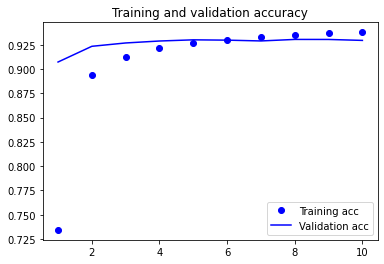

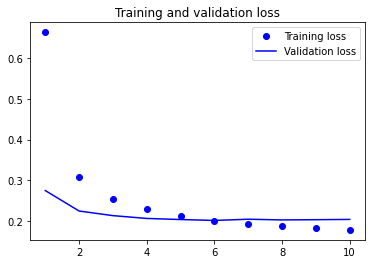

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Test on a few random headline that i just found online:

In [ ]:
txt = ["100-year-old TB vaccine may lower COVID risk for elders, says ICMR study"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

[[5.4609794e-05 2.6972016e-04 5.0512739e-05 9.9962509e-01]] health


In [ ]:
txt = ["Gold and Silver prices record marginal hike on MCX| Check latest rates here"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

[[5.6176889e-04 9.9467444e-01 4.4061844e-03 3.5746724e-04]] bussiness


In [ ]:
txt = ["Realme GT 5G quick review: Supercar design now on a phone"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

[[1.00868405e-04 1.68461481e-03 9.98082757e-01 1.31835637e-04]] science/tech
